## The Kernel

This kernel is an approach to solve the competition problem [CommonLit Readability Prize](https://www.kaggle.com/c/commonlitreadabilityprize).

The problem could be represented by the following paragraph: 

"Can machine learning identify the appropriate reading level of a passage of text, and help inspire learning? Reading is an essential skill for academic success. When students have access to engaging passages offering the right level of challenge, they naturally develop reading skills."

In [4]:
import pandas as pd
import seaborn as sns
import numpy as np
import plotly.express as px
from plotly import graph_objects as go

dataset = pd.read_csv("../input/commonlitreadabilityprize/train.csv")
dataset.head()


def plot_training(history):
    # Creating the plotly figure object
    fig = go.Figure()
    # Adding accuracy line
    fig.add_trace(
        go.Scatter(
            x=np.arange(len(history.history["loss"])),
            y=history.history["loss"],
            text=np.arange(len(history.history["loss"])),
            mode="lines",
            name="loss",
        )
    )
    # Adding val_accuracy line
    fig.add_trace(
        go.Scatter(
            x=np.arange(len(history.history["val_loss"])),
            text=np.arange(len(history.history["val_loss"])),
            y=history.history["val_loss"],
            mode="lines",
            name="val_loss",
        )
    )
    # Formating the graph
    fig.update_layout(title="NN training curve plot.", xaxis_title="Epochs", yaxis_title="Score", title_font_size=24)
    # Showing the image
    fig.show()


# EDA

## First part

Starting the first exploratory data analyses using the columns present in the dataset. 

### Files
- train.csv - the training set
- test.csv - the test set
- sample_submission.csv - a sample submission file in the correct format
### Columns
- id - unique ID for excerpt
- url_legal - URL of source - this is blank in the test set.
- license - license of source material - this is blank in the test set.
- excerpt - text to predict reading ease of
- target - reading ease
- standard_error - measure of spread of scores among multiple raters for each excerpt. Not included for test data.

[Source](https://www.kaggle.com/c/commonlitreadabilityprize/data)

In [5]:
print("Dataset shape", dataset.shape)
dataset.isna().sum()

Dataset shape (2834, 6)


id                   0
url_legal         2004
license           2004
excerpt              0
target               0
standard_error       0
dtype: int64

In the Data descriptions says the licensing information is provided for the public test set (because the associated excerpts are available for display / use), the hidden private test set includes only blank license / legal information.


## id
Just an ID with a hash with a lenght of 8 chars.

In [6]:
print("How many unique values?", len(dataset.id.unique()))
dataset.id.value_counts()[:5]

How many unique values? 2834


701d0ecf7    1
0b405c725    1
c3086ffed    1
657c2e5e9    1
3586e4c55    1
Name: id, dtype: int64

Only one ID per line.

### url_legal
Looks like the link that you can find the text...

In [7]:
print("How many missing values?", dataset.url_legal.isna().sum())
dataset.url_legal.sample(3)

How many missing values? 2004


2586                                  NaN
323                                   NaN
713     https://www.africanstorybook.org/
Name: url_legal, dtype: object

### license

In [8]:
print("How many missing values?", dataset.license.isna().sum())
dataset.license.value_counts()

How many missing values? 2004


CC BY 4.0                                 391
CC BY-SA 3.0 and GFDL                     196
CC BY-SA 3.0                              192
CC BY-NC-SA 2.0                            26
CC BY 3.0                                   7
CC BY-NC-SA 4.0                             4
CC BY-NC-ND 4.0                             3
CC BY NC-SA 2.0                             2
CC BY-NC-SA 3.0                             2
CC BY-NC                                    2
GNU Free Document License, version 1.2      1
CC-BY-SA                                    1
CC-BY-NC                                    1
CC BY-NC 3.0                                1
CC BY-NC 2.0                                1
Name: license, dtype: int64

### excerpt

In [9]:
print("How many missing values?", dataset.excerpt.isna().sum())
print("How many unique values?", len(dataset.excerpt.unique()))
dataset["excerpt_len"] = dataset.excerpt.apply(len)
print("How big or how small is the texts?")
fig = px.box(dataset, y="excerpt_len", width=300, title="Boxpot excerpt_len column.")
fig.show()

How many missing values? 0
How many unique values? 2834
How big or how small is the texts?


The smaller text has 669 chars, and the bigger has 1341 chars.

Just an example...

In [10]:
dataset.excerpt.iloc[0]

'When the young people returned to the ballroom, it presented a decidedly changed appearance. Instead of an interior scene, it was a winter landscape.\nThe floor was covered with snow-white canvas, not laid on smoothly, but rumpled over bumps and hillocks, like a real snow field. The numerous palms and evergreens that had decorated the room, were powdered with flour and strewn with tufts of cotton, like snow. Also diamond dust had been lightly sprinkled on them, and glittering crystal icicles hung from the branches.\nAt each end of the room, on the wall, hung a beautiful bear-skin rug.\nThese rugs were for prizes, one for the girls and one for the boys. And this was the game.\nThe girls were gathered at one end of the room and the boys at the other, and one end was called the North Pole, and the other the South Pole. Each player was given a small flag which they were to plant on reaching the Pole.\nThis would have been an easy matter, but each traveller was obliged to wear snowshoes.'

### wordcloud (without process)
Just a word cloud plot to identify the most common words in the dataset.

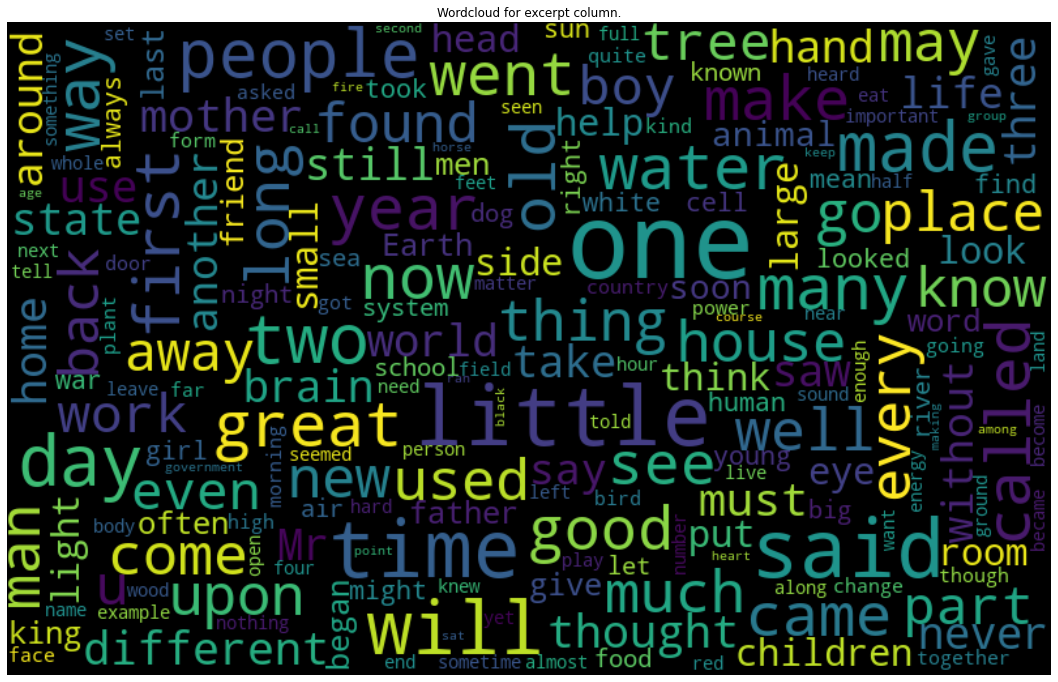

In [11]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


def wordcloud(df, column_name, title):
    all_words = " ".join([text for text in df[column_name]])
    wordcloud = WordCloud(
        width=800, height=500, max_font_size=80, collocations=False
    ).generate(all_words)
    plt.figure(figsize=(24, 12))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()


wordcloud(dataset, "excerpt", "Wordcloud for excerpt column.")

### target
Reading ease information.

In [12]:
dataset.target.describe()

count    2834.000000
mean       -0.959319
std         1.033579
min        -3.676268
25%        -1.690320
50%        -0.912190
75%        -0.202540
max         1.711390
Name: target, dtype: float64

In [13]:
fig = px.histogram(dataset, x="target", width=600, title="Boxpot target column.")
fig.show()

Continuous values that could be negative, zero or positive. A perfect gaussian distribution.

### standard_error

In [14]:
dataset.standard_error.describe()

count    2834.000000
mean        0.491435
std         0.034818
min         0.000000
25%         0.468543
50%         0.484721
75%         0.506268
max         0.649671
Name: standard_error, dtype: float64

In [15]:
fig = px.box(
    dataset, y="standard_error", width=300, title="Boxpot standard_error column."
)
fig.show()

### There is relation between the text size and dificulty to read? 

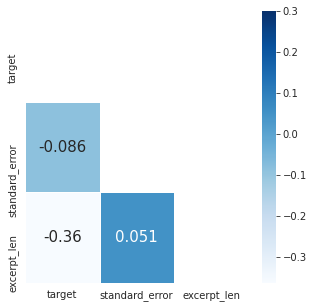

In [16]:
with sns.axes_style("white"):
    table = dataset.corr()
    mask = np.zeros_like(table)
    mask[np.triu_indices_from(mask)] = True
    plt.figure(figsize=(5, 5))
    sns.heatmap(
        table,
        cmap="Blues",
        mask=mask,
        vmax=0.3,
        linewidths=0.5,
        annot=True,
        annot_kws={"size": 15},
    )

There is a considerable inverse correlation between target and excerpt lenght!

# NLP

- 1 - Remove stopwords and ponctuation.
- 2 - TFDIF (word frequency).
- 3 - Regression.
- 4 - XAI - SHAP.

### Remove stowords and ponctuation

In [17]:
import string
from nltk.corpus import stopwords
import nltk
from nltk.stem import SnowballStemmer


stemmer = nltk.SnowballStemmer("english")
stopwords = list(stopwords.words("english"))
punctuation = [word for word in string.punctuation]
punctuation += ["...", "  ", "\n"]


def remove_punctuation(serie, stopwords):
    aux = list()
    for el in serie:
        for word in stopwords:
            el = el.replace(word, " ")
        aux.append(el)
    return aux


def remove_stopwords(serie, stopwords):
    tokenizer = nltk.WordPunctTokenizer()

    result_serie = list()
    for row in serie:
        aux = list()
        text_row = tokenizer.tokenize(row.lower())
        for word in text_row:
            if word not in stopwords:  # stopwords
                aux.append(stemmer.stem(word))
        result_serie.append(" ".join(aux))
    return result_serie


dataset["excerpt_cleaned"] = dataset.excerpt.str.lower()
dataset["excerpt_cleaned"] = remove_stopwords(dataset.excerpt_cleaned, punctuation)
dataset["excerpt_cleaned"] = remove_stopwords(dataset.excerpt_cleaned, stopwords)
dataset["excerpt_cleaned"]

0       young peopl return ballroom present decid chan...
1       dinner time mrs fayr somewhat silent eye rest ...
2       roger predict snow depart quick came two day s...
3       outsid befor palac great garden wall round fil...
4       onc upon time three bear live togeth hous wood...
                              ...                        
2829    think dinosaur live pictur see hot steami swam...
2830    solid solid usual hard becaus molecul pack tog...
2831    second state matter discuss liquid solid hard ...
2832    solid shape actual touch three dimen mean leng...
2833    anim made mani cell eat thing digest insid ani...
Name: excerpt_cleaned, Length: 2834, dtype: object

### TFDIF (word frequency) and feature transformation

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

vectorize = TfidfVectorizer(min_df=50,  max_features=None, 
            strip_accents='unicode', analyzer='word', token_pattern=r'\w{1,}',
            ngram_range=(1, 5), use_idf=1, smooth_idf=1, sublinear_tf=1,
            stop_words = 'english')

ohe = OneHotEncoder()
mms_X = MinMaxScaler()
mms_y = MinMaxScaler()

dataset = dataset[['license','excerpt_len','excerpt_cleaned', 'target']]
dataset['license'] = dataset.license.fillna("Not Known")


X_train, X_test, y_train, y_test = train_test_split(
    dataset.drop('target',axis=1), dataset.target , test_size=0.10, random_state=42
)

def feature_transformation(X_raw, y_raw,  vectorize, ohe, mms_X, mms_y, fit=True):
    if fit:
        ohe.fit(X_raw.license.values.reshape(-1, 1))
        mms_X.fit(X_raw.excerpt_len.values.reshape(-1, 1))
        vectorize.fit(X_raw["excerpt_cleaned"])
        mms_y.fit(y_raw.values.reshape(-1,1))
            
    X = np.concatenate(
        (
            ohe.transform(X_raw.license.values.reshape(-1, 1)).todense(),
            mms_X.transform(X_raw.excerpt_len.values.reshape(-1, 1)),
            vectorize.transform(X_raw["excerpt_cleaned"]).todense(),
        ),
        axis=1,
    )
    y = mms_y.transform(y_raw.values.reshape(-1,1))
    return X,y

X_train, y_train = feature_transformation(X_train, y_train, vectorize, ohe, mms_X, mms_y,  fit=True)
X_test, y_test = feature_transformation(X_test, y_test,vectorize, ohe, mms_X, mms_y,  fit=False)

print("How many features (bag of words): ", len(vectorize.get_feature_names()))
print("Dataset shape: ", X_train.shape)

How many features (bag of words):  696
Dataset shape:  (2550, 713)


##  Y target transformed

In [19]:

aux = pd.DataFrame(y_train)
aux.columns = ['Y_value']

fig = px.histogram(aux, x="Y_value", nbins=50)
fig.show()

### Regression


Regression using neural network and target scalded with values between 0~1.

In [20]:
from sklearn.metrics import r2_score
import tensorflow as tf
from tensorflow.keras.layers import (Dense, Dropout,Conv1D,GlobalMaxPooling1D, Embedding, BatchNormalization)
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop,Adam

INPUT_SIZE = X_train.shape[1]
callback = EarlyStopping(monitor="loss", patience=5)

def plot_history(history):
    acc = history.history['mae']
    val_acc = history.history['val_mae']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training mae')
    plt.plot(x, val_acc, 'r', label='Validation mae')
    plt.title('Training and validation mae')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    
def baseline_model(neurons=1000, hidden_lenght=10, learning_rate=0.0001, dropout=0.2):

    model = Sequential()
    model.add(Dense(neurons, input_dim=INPUT_SIZE, activation='relu'))
    model.add(Dropout(dropout))
    
    for _ in range(1,hidden_lenght + 1):
        model.add(Dense(neurons, activation='relu'))
        model.add(Dropout(dropout))
        
    model.add(Dense(1))
    
    optimizer = Adam(lr=learning_rate)
    model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mae', 'mse'])

    return model

Traning the model

In [21]:
model = baseline_model(
    neurons=2000,
    hidden_lenght=10,
    learning_rate=0.001,
    dropout=0.2
)

history = model.fit(
    X_train, y_train, batch_size=5,
    validation_data=(X_test, y_test),
    epochs=100,
    verbose=1,
    callbacks=[callback],
)
print('R2 score:',r2_score(y_test, model.predict(X_test)))
plot_training(history)

Epoch 1/100
510/510 [==============================] - 6s 8ms/step - loss: 0.1563 - mae: 0.2374 - mse: 0.1563 - val_loss: 0.0228 - val_mae: 0.1208 - val_mse: 0.0228
Epoch 2/100
510/510 [==============================] - 4s 7ms/step - loss: 0.0260 - mae: 0.1274 - mse: 0.0260 - val_loss: 0.0290 - val_mae: 0.1406 - val_mse: 0.0290
Epoch 3/100
510/510 [==============================] - 4s 7ms/step - loss: 0.0246 - mae: 0.1257 - mse: 0.0246 - val_loss: 0.0219 - val_mae: 0.1190 - val_mse: 0.0219
Epoch 4/100
510/510 [==============================] - 4s 7ms/step - loss: 0.0170 - mae: 0.1015 - mse: 0.0170 - val_loss: 0.0200 - val_mae: 0.1126 - val_mse: 0.0200
Epoch 5/100
510/510 [==============================] - 4s 7ms/step - loss: 0.0116 - mae: 0.0847 - mse: 0.0116 - val_loss: 0.0219 - val_mae: 0.1185 - val_mse: 0.0219
Epoch 6/100
510/510 [==============================] - 4s 7ms/step - loss: 0.0096 - mae: 0.0778 - mse: 0.0096 - val_loss: 0.0220 - val_mae: 0.1187 - val_mse: 0.0220
Epoch 7/10

# Submission

Loading the submision dataset.

In [22]:
submission = pd.read_csv("../input/commonlitreadabilityprize/test.csv")
submission["excerpt_cleaned"] = submission.excerpt.str.lower()
submission["excerpt_cleaned"] = remove_stopwords(
    submission.excerpt_cleaned, punctuation
)
submission["excerpt_cleaned"] = remove_stopwords(submission.excerpt_cleaned, stopwords)
submission["excerpt_len"] = submission.excerpt.apply(len)

Formating the submission dataset.

In [23]:
X_sub = np.concatenate(
    (
        ohe.transform(
            submission.license.fillna("Not Known").values.reshape(-1, 1)
        ).todense(),
        mms_X.transform(submission.excerpt_len.values.reshape(-1, 1)),
        vectorize.transform(submission["excerpt_cleaned"]).todense(),

    ),
    axis=1,
)

Prediction the new dataset.

In [25]:
submission["target"] = mms_y.inverse_transform(model.predict(X_sub))
submission[["id", "target"]].to_csv("submission.csv", index=False)